In [1]:
# Establece las librerias del sistema
# Manejo de datos
import pandas as pd
import numpy as np
# Maejo de directorios y archivos
import os
import glob
# Librerias de pronotiscos
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.stats.outliers_influence import summary_table
from statsmodels.tsa.seasonal import seasonal_decompose
# Advertencias del sistema
import warnings
warnings.filterwarnings('ignore')



# Funciones internas
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
def wmape(actual, forecast):
    actual,forecast = np.array(actual), np.array(forecast)
    se_mape = np.abs(actual-forecast)/actual
    ft_actual_sum = np.sum(actual)
    se_actual_prod_mape = actual * se_mape
    ft_actual_prod_mape_sum = np.sum(se_actual_prod_mape)
    ft_wmape_forecast = ft_actual_prod_mape_sum / ft_actual_sum
    return ft_wmape_forecast * 100

In [2]:

categoria =  'CarnicosData'
vista = categoria + "-ini"
path = ( categoria +  '.xlsx')
xl = pd.ExcelFile(path)
fecha_inicio = '2020-03-02'
pproyeccion = 72
print(xl.sheet_names)


df0 = xl.parse('dt')
df1= pd.DataFrame(df0)


dir_actual = os.getcwd()

Pais = "Carnico-Periodo-6Meses2"

path = os.path.join(dir_actual, Pais)
path2 = os.path.join(dir_actual, Pais,"reportes")
try:
    os.mkdir(path)
    os.mkdir(path2)
except:
  print("An exception occurred")


['Hoja2', 'Hoja3', 'E3', 'e2', 'e1', 'dt2', 'dt', 'dt1']
An exception occurred


In [3]:
e1 = pd.pivot_table(df1, values='Cantidad', index=['Fecha'],columns=['Linea'], aggfunc=np.sum)
tpath = os.path.join(path,"Lineas.xlsx")
e1['Periodo'] = pd.date_range(start="2/02/2020", periods=e1.shape[0], freq="W")
e1.to_excel(tpath)
print(e1)


Linea       Chorizo y Variedades    Salchicha    Periodo
Fecha                                                   
2020-03-02            282166.047  1079965.096 2020-02-02
2020-03-09            299151.658  1142863.117 2020-02-09
2020-03-16            367175.023  1381084.385 2020-02-16
2020-03-23            317525.847  1306365.189 2020-02-23
2020-03-30            315382.136  1366658.005 2020-03-01
...                          ...          ...        ...
2023-01-09            432397.768  1509996.229 2022-12-18
2023-01-16            324708.342  1323359.776 2022-12-25
2023-01-23            360031.838  1464297.433 2023-01-01
2023-01-30            354737.917  1459795.078 2023-01-08
2023-02-06            323462.047  1366814.121 2023-01-15

[155 rows x 3 columns]


In [4]:
dfc = df1[(df1.Linea == 'Chorizo y Variedades')]
dfs = df1[(df1.Linea == 'Salchicha')]
e2c = pd.pivot_table(dfc, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum, margins=True,margins_name="Total")
e2s = pd.pivot_table(dfs, values='Cantidad', index=['Fecha'],columns=['Centro Distribución'], aggfunc=np.sum,margins=True,margins_name="Total")
#Copia el dataframe para rellenar con menor sesgo posteriormente
#Chorizos
e2cn = e2c.copy(deep=True)
Ntotalc =e2c["Total"]/e2c["Total"].loc["Total"]
e2cn.iloc[0:155] = e2c.loc["Total"]
e2c["NTotal"] = Ntotalc
e2cn = e2cn.multiply(e2c["NTotal"], axis = "index")
#Salchichas
e2sn = e2s.copy(deep=True)
Ntotals =e2s["Total"]/e2s["Total"].loc["Total"]
e2sn.iloc[0:155] = e2s.loc["Total"]
e2s["NTotal"] = Ntotals
e2sn = e2sn.multiply(e2s["NTotal"], axis = "index")

spath = os.path.join(path,"CenDis_Salchicha_Procesado.xlsx")
cpath = os.path.join(path,"CenDis_Chorizo_Procesado.xlsx")
#Rellena dt con los datos de menor sesgo
e2c = e2c.fillna(e2cn)
e2s= e2s.fillna(e2sn)


e2c.to_excel(cpath)
e2s.to_excel(spath)

In [5]:
cdlist = df1["Centro Distribución"].unique()
pivotlistc = {}
pivotlists = {}
pivotlistc2 = {}
pivotlists2 = {}
#Crea las tablas pivote de material por centro de distribucion
for Cd in cdlist:
    dfccd = dfc[(dfc["Centro Distribución"] == Cd)]
    dfscd = dfs[(dfs["Centro Distribución"] == Cd)]

    e3c = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3s = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum)
    e3c2 = pd.pivot_table(dfccd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    e3s2 = pd.pivot_table(dfscd, values='Cantidad', index=['Fecha'],columns=['Codmat'], aggfunc=np.sum, margins=True,margins_name="Total")
    pivotlistc[Cd]=(e3c)
    pivotlists[Cd]=(e3s)
    pivotlistc2[Cd]=(e3c2)
    pivotlists2[Cd]=(e3s2)
print(pivotlists["NN18"])


Codmat      M1000031  M1000814  M1000820  M1000821  M1000833  M1000840  \
Fecha                                                                    
2020-03-02   701.195   486.851  1656.609  1134.815   881.475    83.545   
2020-03-09   834.006   311.220  2074.055  1525.621   980.146    95.945   
2020-03-16   743.755  1717.170  3135.832  1083.117   856.982    81.995   
2020-03-23   675.452   653.380  2788.510   286.701  1306.517    28.211   
2020-03-30   833.723   673.400  3075.938   425.585  1296.165    22.940   
...              ...       ...       ...       ...       ...       ...   
2023-01-09  2526.750   285.000  5153.000  2503.000  1617.500   287.500   
2023-01-16  2251.469   348.000  4564.000  2492.875  1360.563   343.000   
2023-01-23  2048.250   510.000  5125.500  2522.547  1317.500   250.000   
2023-01-30  1999.750   607.000  5780.000  2547.115  1377.500   372.500   
2023-02-06  1765.000   395.000  4878.500  2467.067  1034.500   297.500   

Codmat      M1000845  M1000849   M100

In [6]:
sframe = pd.DataFrame()
cframe = pd.DataFrame()
#Dataframe de las categorias
cframe.index = ['A','B','C']
sframe.index = ['A','B','C']
dfproyeccioness = {}
dfproyeccionesc = {}
matstoprojects = {}
matstoprojectc = {}

def categoria(x):
    if x == 100:
        return 'A'
    elif x >= 90:
        return 'B'
    elif x < 90 or x is None:
        return 'C'

def matrizsesgo(x2,rows):
    xn = x2.copy(deep=True)

    Ntotalc =x2["Total"]/x2["Total"].loc["Total"]
    xn.iloc[0:rows] = xn.loc["Total"]
    x2["NTotal"] = Ntotalc
    xcn = xn.multiply(x2["NTotal"], axis = "index")
    return xcn

for cd in cdlist:
    df2 = pivotlistc[cd]
    df2t = pivotlistc2[cd]
    rowsch = df2t.shape[0]
    mirrorc = matrizsesgo(df2t,rowsch)
    #Cuenta los datos no vacios, convierte a porcentaje y categoriza
    df3 = df2.count()
    df3 = df3.divide(155).multiply(100)
    df3a= df3.apply(categoria)
    aprovedc = df3a[df3a == "A"]
    aprovedc = list(aprovedc.index.values)
    matstoprojectc[cd] = aprovedc
    df3a=df3a.value_counts()
    cframe[cd] = df3a

    df4 = pivotlists[cd]
    df4t = pivotlists2[cd]
    rowssal = df4t.shape[0]
    mirrors = matrizsesgo(df4t,rowssal)
    df5 = df4.count()
    df5 = df5.divide(155).multiply(100)
    df5a= df5.apply(categoria)
    aproveds = df5a[df5a == "A"]
    aproveds = list(aproveds.index.values)
    matstoprojects[cd] = aproveds
    df5a=df5a.value_counts()
    sframe[cd] = df5a

    df2.fillna(mirrorc, inplace=True)
    df4.fillna(mirrors, inplace=True)
    dfproyeccionesc[cd] = df2
    dfproyeccioness[cd] = df4

spath = os.path.join(path,"Reporte_Salchichas ABC.xlsx")
cpath = os.path.join(path,"Reporte_Chorizos ABC.xlsx")
#Guarda el reporte en excel
print(sframe)
print(cframe)
sframe.to_excel(spath, index_label="Periodo")
cframe.to_excel(cpath, index_label="Periodo")
print("Termino")

   NN13  NN14  NN18  NN20  NN21  NN24  NN27  NN29  NN53  NN97  NNB1  NNB2  \
A    30    27    30    24    27    22    16    25    24    25   NaN    23   
B     5     8     5    10     8    12    15     7     8    10  21.0     6   
C     7     7     9     6     5     8     7     8     4     4  10.0     8   

   NNB8  
A    25  
B     8  
C     5  
   NN13  NN14  NN18  NN20  NN21  NN24  NN27  NN29  NN53  NN97  NNB1  NNB2  \
A     2     2     3   NaN     2    11   NaN     3     1     1     1   NaN   
B    18    18    12  13.0    11     2  13.0    10    12    19    11  13.0   
C     3     3     2   2.0     2     2   2.0     3     2     3     1   2.0   

   NNB8  
A   NaN  
B  14.0  
C   2.0  
Termino


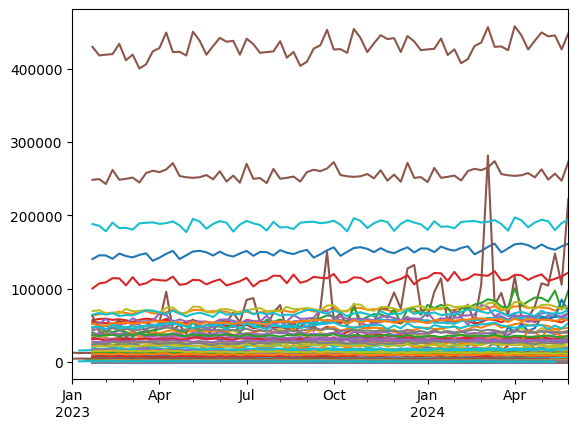

In [7]:
errores = []

def Proyeccion(cd,columnName,df3,periodos,ptrend,pseasonal,pdamped,puse,tipo):
        df10 = df3[df3[columnName] > 0]
        df10 = df10[['Periodo', columnName]]
        df10 = df10.set_index('Periodo')
     
        #df10.plot(figsize=(12, 5))
        # Analisis de descomposicion
        #components = seasonal_decompose(df10, period=8)
        #components.plot()
        # Proyeccion
        fit1 = ExponentialSmoothing(df10, seasonal_periods=periodos,trend=ptrend,seasonal=pseasonal,damped_trend=pdamped,use_boxcox=puse,initialization_method="estimated",missing="drop").fit()
        #print(fit1.summary())
        # Calcula el intervalo de confianza al 95% y lo salva
        xhat = fit1.forecast(steps= pproyeccion)
        z = 1.96
        sse = fit1.sse
        predint_xminus = xhat - z * np.sqrt(sse/len(df10))
        predint_xplus  = xhat + z * np.sqrt(sse/len(df10))

        df = [predint_xminus,predint_xplus]
        df = pd.DataFrame(df)
        df = df.transpose()
        col0 = columnName + "_minimo"
        col1 = columnName + "_maximo"

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)

        # Salva los intervalos

        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+vista + '-_intervalo_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        #df.to_excel(dirPath, index_label="Periodo")


        # Intervalo de confianza por simulacion
        simulations = fit1.simulate(pproyeccion, repetitions=1, error="add", random_errors=None)
        #ax = df10.plot(figsize=(12, 5),marker="o",color="black",title="Proyeccion",)
        #ax.set_ylabel("Venta")
        #ax.set_xlabel("Periodo")
        #fit1.fittedvalues.plot(ax=ax, style="--", color="green")
        #fit1.forecast(steps=pproyeccion).rename("Proyeccion").plot(ax=ax, style="--", marker="o", color="green", legend=True )


        # Grafica la serie de Ajuste y la añade a fit1
        df6 = fit1.forecast(pproyeccion)
        df6.plot()
        df7 = fit1.predict(0)

        df8 = [df7,df6]

        #df1 = (df0[[columnName]])

        df = pd.DataFrame(df8)
        df = df.transpose()
        col0 = columnName + "_ajuste"
        col1 = columnName + "_proyeccion"
        col2 = columnName 

        # Changing columns name with index number
        mapping = {df.columns[0]: col0, df.columns[1]: col1}
        df = df.rename(columns=mapping)
        df = df.fillna(0)
        df[col2] = df[col1].add(df10[columnName],fill_value=0)
        # Salva la proyeccion normal
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+ vista + '-py_'+columnName+'.xlsx'
        dirPath = os.path.join(mdir, mfila)
        df.to_excel(dirPath, index_label="Periodo")

        # Calcula el Error por medio del MAPE
        df99 = [df7]
        yy = pd.DataFrame(df99)
        yy = yy.transpose()
        xx = pd.DataFrame(df10)
        errores.append({"cd":cd+"-"+tipo+"-"+columnName,"Mape":mape(xx,yy),"wmape":wmape(xx,yy),"tipo":tipo})

def Procesamiento(df,cd,tipo):
    for (columnName, columnData) in df.items():
        #print('Column Name : ', columnName)
        #print('Column Contents : ', columnData.values)
        # Parametros personalizados
        ptrend = 'add'
        pseasonal = 'add'
        pdamped = False
        puse = True
        periodos = 24

        if (columnName != 'Periodo') :
           try:
                Proyeccion(cd,columnName,df,periodos,ptrend,pseasonal,pdamped,puse,tipo)
           except:
                Proyeccion(cd,columnName,df,4,ptrend,pseasonal,pdamped,puse,tipo)


for cd in cdlist:

    totalcds = e2s[cd]
    totalcds = totalcds.drop("Total")
    totalcdc = e2c[cd]
    totalcdc = totalcdc.drop("Total")



    dfps2 = dfproyeccioness[cd]
    dfps2 = dfps2.loc[:, dfps2.columns.isin(matstoprojects[cd])]
    dfps2['Total'] = totalcds
    dfps2['Periodo'] = pd.date_range(start="2/02/2020", periods=dfps2.shape[0], freq="W")
    dfps2.to_excel(cd +"test.xlsx", index_label="Periodo")
    Procesamiento(dfps2,cd,"Salchicha")

    dfpc2 = dfproyeccionesc[cd]
    dfpc2 = dfpc2.loc[:, dfpc2.columns.isin(matstoprojectc[cd])]
    dfpc2['Total'] = totalcdc
    dfpc2['Periodo'] = pd.date_range(start="2/02/2020", periods=dfpc2.shape[0], freq="W")
    dfpc2.to_excel(cd +"testc.xlsx", index_label="Periodo")
    Procesamiento(dfpc2,cd,"Chorizo")
    dferrores = pd.DataFrame(errores)
 


In [8]:
#Errores a excel:
mdir2 = os.path.join(dir_actual, Pais,"reportes")
mfilac = vista + '-CentroDistribucion-Chorizos-Errores.xlsx'
dirPathc = os.path.join(mdir2, mfilac)
mfilas = vista + '-CentrosDistribucion-Salchichas-Errores.xlsx'
dirPaths = os.path.join(mdir2, mfilas)
print(dferrores)
dfes = dferrores[dferrores["tipo"]== "Salchicha"]
dfec = dferrores[dferrores["tipo"]== "Chorizo"]
dfes.to_excel(dirPaths)
dfec.to_excel(dirPathc)

# Une la salida

for cd in cdlist:
    for tipo in ["Salchicha","Chorizo"]:
        df=[]

        mdir = os.path.join(dir_actual, Pais)
        mfila = os.path.join(mdir, cd +"-"+tipo+"-"+ vista + "-py*")
        files = glob.glob(mfila)
        #print(mfila)
        for a in files:
            df.append( pd.read_excel(a, sheet_name='Sheet1'))

        i = 0
        for x in df:
            if i > 0 :
                dt = pd.merge(dt, df[i])
            else :
                dt = df[0]
            i = i + 1
       
        # Salva la proyeccion final de cada serie
        mdir = os.path.join(dir_actual, Pais)
        mfila = cd+"-"+tipo+"-"+ vista + '-Reporte_Final.xlsx'
        dirPath = os.path.join(mdir2,tipo, mfila)
        dt= dt.set_index('Periodo')
        dt = dt[dt.columns.drop(list(dt.filter(regex='_ajuste')))]
        dt = dt[dt.columns.drop(list(dt.filter(regex='_proyeccion')))]
        dt2= dt.iloc[:, :-1].sum(axis=1)
        dt['A'] = dt2
        dt['B+C'] = dt['Total'] - dt['A']
        dt.insert(0, 'B+C', dt.pop('B+C'))
        dt.insert(0, 'A', dt.pop('A'))
        print(dt)
        dt.to_excel(dirPath)

      

                          cd       Mape      wmape       tipo
0    NN13-Salchicha-M1000497  14.819532  15.148712  Salchicha
1    NN13-Salchicha-M1000794  16.669579  16.775827  Salchicha
2    NN13-Salchicha-M1000820  14.444414  13.627888  Salchicha
3    NN13-Salchicha-M1000821  52.213750  26.571598  Salchicha
4    NN13-Salchicha-M1000833  14.887651  14.386855  Salchicha
..                       ...        ...        ...        ...
345  NNB8-Salchicha-M1043327   9.471033   9.164770  Salchicha
346  NNB8-Salchicha-M1043643  10.255555   9.616381  Salchicha
347  NNB8-Salchicha-M1046292   5.837214   5.955112  Salchicha
348     NNB8-Salchicha-Total   7.914338   7.917670  Salchicha
349       NNB8-Chorizo-Total  11.928562  11.094516    Chorizo

[350 rows x 4 columns]
                        A           B+C     M1000497     M1000794    M1000820  \
Periodo                                                                         
2020-02-02  119553.831000   7556.005000  1891.000000  4370.000000  489

                       A           B+C      M1037101     M1039602  \
Periodo                                                             
2020-02-02  12897.000000  14806.162000  11474.000000  1423.000000   
2020-02-09  15110.000000  14870.646000  12510.000000  2600.000000   
2020-02-16  16349.000000  16205.183000  14316.000000  2033.000000   
2020-02-23  14760.500000  14018.203000  12856.500000  1904.000000   
2020-03-01  16820.000000  16286.810000  14139.000000  2681.000000   
...                  ...           ...           ...          ...   
2024-05-05  19949.318174   9974.945108  15901.872938  4047.445236   
2024-05-12  18368.492092  10474.136341  14041.742628  4326.749464   
2024-05-19  17518.421738  12068.124307  14459.994129  3058.427609   
2024-05-26  19101.405991  11295.792082  14727.627261  4373.778730   
2024-06-02  18747.072781  11232.390651  15031.007037  3716.065744   

                   Total  
Periodo                   
2020-02-02  27703.162000  
2020-02-09  29980.646

              A           B+C         Total
Periodo                                    
2020-02-02  0.0   7992.347000   7992.347000
2020-02-09  0.0   8243.422000   8243.422000
2020-02-16  0.0  10161.588000  10161.588000
2020-02-23  0.0  10399.584000  10399.584000
2020-03-01  0.0   9740.502000   9740.502000
...         ...           ...           ...
2024-04-14  0.0  14461.027955  14461.027955
2024-04-21  0.0  13966.669370  13966.669370
2024-04-28  0.0  13720.745973  13720.745973
2024-05-05  0.0  13715.049967  13715.049967
2024-05-12  0.0  14055.316503  14055.316503

[224 rows x 3 columns]
                        A           B+C    M1000031    M1000814     M1000820  \
Periodo                                                                        
2020-02-02   84824.546000   8732.306000  635.000000   85.000000  2045.000000   
2020-02-09   87342.507000   8806.068000  780.750000   58.000000  2294.000000   
2020-02-16  109021.348000   9547.469000  790.750000  149.000000  3589.500000   
2020

                       A          B+C     M1000195    M1000209      M1034258  \
Periodo                                                                        
2020-02-02  30064.950000  1134.000000  1585.000000  280.000000   5399.000000   
2020-02-09  29216.186000  1197.000000  1688.000000  366.000000   4030.000000   
2020-02-16  43017.940000  2241.000000  2948.000000  776.000000   8071.000000   
2020-02-23  36477.754000  1962.000000  2078.000000  389.000000   5800.667000   
2020-03-01  41626.172000  1930.000000  2252.000000  319.000000   7040.333000   
...                  ...          ...          ...         ...           ...   
2024-05-05  57551.425873   148.409233  2968.342274  532.286642  11663.854654   
2024-05-12  54973.771402  3069.727131  3007.086278  510.011643  11240.242870   
2024-05-19  52512.277261  3503.743711  2602.483679  383.606855  11093.557704   
2024-05-26  56859.638967  1723.459553  3348.361210  522.746023  11109.398503   
2024-06-02  54509.647428  2595.690871  2

                       A           B+C     M1000195      M1037101  \
Periodo                                                             
2020-02-02  31885.575000  22854.726000  3745.000000  21727.575000   
2020-02-09  31800.220000  24423.394000  3705.000000  20517.970000   
2020-02-16  44447.577000  33333.220000  5042.000000  32363.577000   
2020-02-23  41277.510000  24713.343000  5539.000000  29287.510000   
2020-03-01  33807.167000  21110.227000  5033.000000  23882.667000   
...                  ...           ...          ...           ...   
2024-05-05  39709.362736  30534.329856  5064.091189  26967.885819   
2024-05-12  37645.754726  28349.092355  4391.336876  25914.857382   
2024-05-19  38210.633329  28422.080222  4446.041659  26322.179413   
2024-05-26  37939.114745  28733.025002  4522.609411  26104.015851   
2024-06-02  41724.373458  30496.733771  4649.481180  29137.696292   

               M1037102         Total  
Periodo                                
2020-02-02  6413.00000

              A          B+C        Total
Periodo                                  
2020-02-02  0.0  4620.876000  4620.876000
2020-02-09  0.0  4836.764000  4836.764000
2020-02-16  0.0  6045.986000  6045.986000
2020-02-23  0.0  5162.964000  5162.964000
2020-03-01  0.0  5791.388000  5791.388000
...         ...          ...          ...
2024-04-14  0.0  5226.330072  5226.330072
2024-04-21  0.0  5034.697191  5034.697191
2024-04-28  0.0  5188.964272  5188.964272
2024-05-05  0.0  4961.493679  4961.493679
2024-05-12  0.0  5229.711728  5229.711728

[224 rows x 3 columns]
                     A          B+C    M1037101        Total
Periodo                                                     
2020-02-02   31.000000   865.502000   31.000000   896.502000
2020-02-09   20.000000  1034.168000   20.000000  1054.168000
2020-02-16   51.000000   913.167000   51.000000   964.167000
2020-02-23   42.000000   738.750000   42.000000   780.750000
2020-03-01   51.000000   822.167000   51.000000   873.167000
...

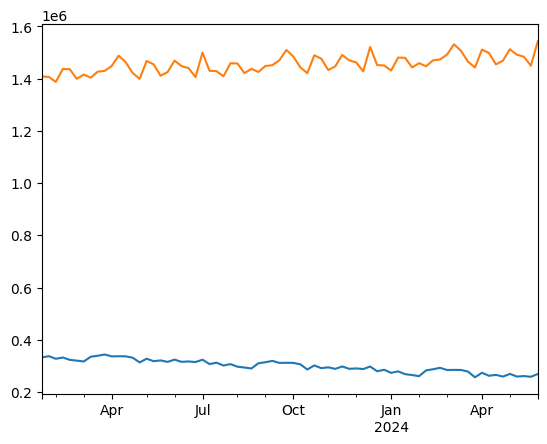

In [9]:
Procesamiento(e1,"Lineas","Proyeccion")
df=[]

mdir = os.path.join(dir_actual, Pais)
mfila = os.path.join(mdir, "Lineas-Proyeccion-CarnicosData-ini-py*")
files = glob.glob(mfila)
#print(mfila)
for a in files:
    df.append( pd.read_excel(a, sheet_name='Sheet1'))

i = 0
for x in df:
    if i > 0 :
        dt = pd.merge(dt, df[i])
    else :
        dt = df[0]
    i = i + 1
       
# Salva la proyeccion final de cada serie
mdir = os.path.join(dir_actual, Pais)
mfila = 'Lineas-Proyeccion-CarnicosData-Reporte_Final.xlsx'
dirPath = os.path.join(mdir, mfila)
dt= dt.set_index('Periodo')
dt = dt[dt.columns.drop(list(dt.filter(regex='_ajuste')))]
dt = dt[dt.columns.drop(list(dt.filter(regex='_proyeccion')))]
dt.to_excel(dirPath)